# Assignment 3

In this analysis five different datasets are selected from http://www.timeseriesclassification.com/. Several models are trained for each dataset. Two different representations each with two different parameter sets are used to build the model. Then, distances between the time series are calculated using 4 different distance measures. In the classification step, 3 different k values are used in the K-NN algorithm. Accuracy of each model is calculated to determine the best performing model. Finally, the best performing model is tested on a seperate test set.

In [ ]:
library(data.table)
library(ggplot2)
library(TSrepr)
library(caret)
library(TSdist)
library(dtw)
library(zoo)
library(rpart)
library(rattle)
require(TunePareto)

setwd("C:/Users/alpsr/Desktop/Assignment 3")

## Dataset 2: PowerCons

In this notebook, Plane dataset is evaluated. This dataset contains 180 training time series and 180 test time series. There are 2 different classes. First six time series in the training dataset are as follows.

In [3]:
dataset = 'PowerCons'
train_data_path=sprintf('%s/%s/%s_TRAIN.txt',getwd(),dataset,dataset)

In [4]:
power = fread(train_data_path)
power <- setnames(power, "V1", "Class")
power <- data.table(power)
power[, "ID" := 1:.N]
power[, "Class" := as.factor(Class)]
setcolorder(power, c("ID", "Class"))
colnames(power) <- c("ID", "Class",seq(1:144))
power_matrix <- as.matrix(power[,c(-1,-2)])
power_long <- melt(power,id.vars = c("ID","Class"))
power_long[,variable := as.numeric(variable)]
power_class <- power$Class
head(power)

ID,Class,1,2,3,4,5,6,7,8,...,135,136,137,138,139,140,141,142,143,144
<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.44,0.40,0.36,0.35,0.35,0.38,0.36,0.35,...,0.77,0.40,0.33,0.29,0.28,0.24,0.22,0.23,0.25,0.25
2,1,0.14,0.19,0.19,0.16,0.16,0.18,0.17,0.16,...,0.48,0.62,0.39,0.17,0.14,0.70,1.25,1.21,1.20,1.24
3,1,0.34,0.34,0.34,0.26,0.18,0.83,1.48,1.36,...,0.84,0.97,1.23,1.49,1.17,0.85,0.83,0.79,0.75,0.73
4,1,1.70,1.50,1.30,3.40,5.50,4.15,2.80,2.67,...,1.62,1.61,1.60,1.59,1.55,1.00,0.55,0.37,0.37,0.36
5,1,1.78,1.59,1.39,1.45,1.45,1.41,1.40,1.45,...,1.36,1.36,1.40,0.81,0.23,0.27,0.29,0.28,0.27,0.27
6,1,0.41,0.30,0.24,0.28,0.28,0.28,0.23,0.25,...,1.27,1.59,1.91,1.65,1.40,1.11,0.81,0.60,0.39,0.32


## Classes

Two classes from the dataset are as follows.

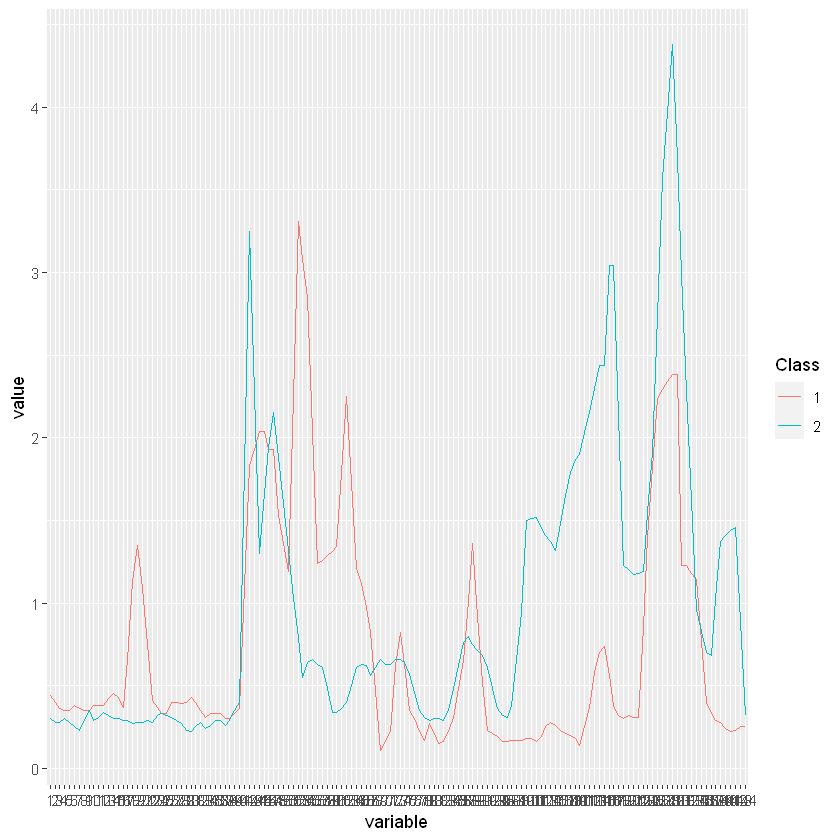

In [5]:
power_class_1 <- melt(power[,head(.SD, 1), Class],id.vars = c("ID","Class"))

ggplot(power_class_1, aes(x = variable, y = value, group = Class)) +
geom_line(aes(color = Class))

## Representations

Two different representations are used in this analysis. First one is PAA (piecewise aggregate approximation) and second is the APCA (Adaptive Piecewise Constant Approximation) using regression trees.

### Piecewise Aggregate Approximation

In [6]:
power_paa_q12 <- repr_matrix(power_matrix,repr_paa,args = list(q = 12,func = meanC))
power_paa_q6 <- repr_matrix(power_matrix,repr_paa,args = list(q = 6, func = meanC))

index1 = seq(1,143, by = 12)
for(i in seq(1,180)){
    power_long[(variable %in% index1) & (ID == i), PAA_q12 := power_paa_q12[i,]]
    power_long[ID == i, PAA_q12_fit_value := power_long[ID == i, na.locf(PAA_q12)]]
}

index2 = seq(1,143, by = 6)
for(i in seq(1,180)){
    power_long[(variable %in% index2) & (ID == i), PAA_q6 := power_paa_q6[i,]]
    power_long[ID == i, PAA_q6_fit_value := power_long[ID == i, na.locf(PAA_q6)]]
}

#power_long[, PAA_q12_fit_value := mean(value), by = .(PAA_q12_fit,ID)]
#power_long[, PAA_q6_fit_value := mean(value), by = .(PAA_q6_fit,ID)]

### Regression Trees

In [7]:
for(i in seq(1,180)){
    selected_series <- power_long[ID == i]
    tree_fit=rpart(value~variable,selected_series,control=rpart.control(maxdepth=3, cp = 0, minsplit = 20, minbucket = 10))
    #fancyRpartPlot(tree_fit)
    power_long[ID == i, Tree_fit_d3 := predict(tree_fit, selected_series)]
}

for(j in seq(1,180)){
    selected_series <- power_long[ID == j]
    tree_fit=rpart(value~variable,selected_series,control=rpart.control(maxdepth=4, cp = 0, minsplit = 20, minbucket = 10))
    #fancyRpartPlot(tree_fit)
    power_long[ID == j, Tree_fit_d4 := predict(tree_fit, selected_series)]
}

head(power_long)

ID,Class,variable,value,PAA_q12,PAA_q12_fit_value,PAA_q6,PAA_q6_fit_value,Tree_fit_d3,Tree_fit_d4
<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0.44,0.3733333,0.3733333,0.3800000,0.3800000,0.5300000,0.3727273
2,1,1,0.14,0.1691667,0.1691667,0.1700000,0.1700000,0.1648485,0.1700000
3,1,1,0.34,0.6116667,0.6116667,0.3816667,0.3816667,0.6630000,0.6630000
4,1,1,1.70,2.7416667,2.7416667,2.9250000,2.9250000,2.7416667,2.7416667
5,1,1,1.78,1.3275000,1.3275000,1.5116667,1.5116667,1.4780000,1.4780000
6,1,1,0.41,0.2825000,0.2825000,0.2983333,0.2983333,0.3036842,0.2825000


## Distance Measures

Three different distances measures are used. First one is the Euclidean Distance. Remaining ones are Dynamic Time Warping (DTW), Longest Common Subsequence (LCSS) and Edit Distance with Real Penalties (ERP).

### Euclidean Distance

In [8]:
power_euclidean_raw <- as.matrix(dist(power_matrix))

power_PAA_q12_matrix <- dcast(power_long, ID + Class ~ variable, value.var = "PAA_q12_fit_value")
power_PAA_q6_matrix <- dcast(power_long, ID + Class ~ variable, value.var = "PAA_q6_fit_value")
power_RegTree_d3_matrix <- dcast(power_long, ID + Class ~ variable, value.var = "Tree_fit_d3")
power_RegTree_d4_matrix <- dcast(power_long, ID + Class ~ variable, value.var = "Tree_fit_d4")

power_euclidean_paa_q12 <- as.matrix(dist(as.matrix(power_PAA_q12_matrix[,c(-1,-2)])))
power_euclidean_paa_q6 <- as.matrix(dist(as.matrix(power_PAA_q6_matrix[,c(-1,-2)])))
power_euclidean_RegTree_d3 <- as.matrix(dist(as.matrix(power_RegTree_d3_matrix[,c(-1,-2)])))
power_euclidean_RegTree_d4 <- as.matrix(dist(as.matrix(power_RegTree_d4_matrix[,c(-1,-2)])))

### Dynamic Time Warping

In [9]:
power_dtw_PAA_q12 <- as.matrix(TSDatabaseDistances(X = power_PAA_q12_matrix[,c(-1,-2)], distance = 'dtw'))
power_dtw_PAA_q6 <- as.matrix(TSDatabaseDistances(X = power_PAA_q6_matrix[,c(-1,-2)], distance = 'dtw'))
power_dtw_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = power_RegTree_d3_matrix[,c(-1,-2)], distance = 'dtw'))
power_dtw_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = power_RegTree_d4_matrix[,c(-1,-2)], distance = 'dtw'))
power_dtw_raw <- as.matrix(TSDatabaseDistances(X = power_matrix, distance = 'dtw'))

### LCSS

In [10]:
power_lcss_raw <- as.matrix(TSDatabaseDistances(X = power_matrix, distance = 'lcss', epsilon = 0.1))
power_lcss_paa_q12 <- as.matrix(TSDatabaseDistances(X = power_PAA_q12_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
power_lcss_paa_q6 <- as.matrix(TSDatabaseDistances(X = power_PAA_q6_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
power_lcss_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = power_RegTree_d3_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
power_lcss_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = power_RegTree_d4_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
#str(power_lcss_paa_q12)

### ERP

In [11]:
power_erp_raw <- as.matrix(TSDatabaseDistances(X = power_matrix, distance = 'erp', g = 0))
power_erp_paa_q12 <- as.matrix(TSDatabaseDistances(X = power_PAA_q12_matrix[,c(-1,-2)], distance = 'erp', g = 0))
power_erp_paa_q6 <- as.matrix(TSDatabaseDistances(X = power_PAA_q6_matrix[,c(-1,-2)], distance = 'erp', g = 0))
power_erp_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = power_RegTree_d3_matrix[,c(-1,-2)], distance = 'erp', g = 0))
power_erp_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = power_RegTree_d4_matrix[,c(-1,-2)], distance = 'erp', g = 0))
#str(power_erp_paa_q12)

## Generating Runs

After building the distance matrices, each model's performance is measured using the 10-fold stratified cross validation with 5 repeats.

### Cross-Validation Runs

In [12]:
set.seed(12435)
cv_indices = generateCVRuns(power_class, ntimes = 5, nfold = 10, 
                            leaveOneOut = FALSE, stratified = TRUE)
str(cv_indices)

List of 5
 $ Run  1:List of 10
  ..$ Fold  1 : int [1:18] 85 145 1 88 66 136 27 76 18 168 ...
  ..$ Fold  2 : int [1:18] 148 79 137 23 77 21 78 22 127 113 ...
  ..$ Fold  3 : int [1:18] 141 16 72 139 71 12 83 17 30 104 ...
  ..$ Fold  4 : int [1:18] 125 132 2 80 15 3 126 5 135 173 ...
  ..$ Fold  5 : int [1:18] 130 124 61 6 25 68 138 149 147 60 ...
  ..$ Fold  6 : int [1:18] 84 82 19 123 7 13 9 143 63 170 ...
  ..$ Fold  7 : int [1:18] 10 146 144 28 74 73 62 14 69 38 ...
  ..$ Fold  8 : int [1:18] 140 128 75 121 129 65 81 150 89 40 ...
  ..$ Fold  9 : int [1:18] 24 70 134 86 4 11 133 90 26 153 ...
  ..$ Fold  10: int [1:18] 142 131 20 29 8 67 64 87 122 39 ...
 $ Run  2:List of 10
  ..$ Fold  1 : int [1:18] 135 8 67 82 81 136 30 70 69 35 ...
  ..$ Fold  2 : int [1:18] 141 87 76 26 146 139 13 78 148 177 ...
  ..$ Fold  3 : int [1:18] 75 140 73 125 85 77 142 143 4 48 ...
  ..$ Fold  4 : int [1:18] 65 145 19 10 74 66 3 122 27 112 ...
  ..$ Fold  5 : int [1:18] 14 123 23 126 17 62 129 121 8

### k-NN Classifier

In [13]:
nn_classify_cv=function(dist_matrix,train_class,test_indices,k=1){
    
    test_distances_to_train=dist_matrix[test_indices,]
    test_distances_to_train=test_distances_to_train[,-test_indices]
    train_class=train_class[-test_indices]
    ordered_indices=apply(test_distances_to_train,1,order)
    
    if(k==1){
        nearest_class=as.numeric(train_class[as.numeric(ordered_indices[1,])])
        nearest_class=data.table(id=test_indices,nearest_class)
    } else {
        nearest_class=apply(ordered_indices[1:k,],2,function(x) {train_class[x]})
        nearest_class=data.table(id=test_indices,t(nearest_class))
    }
    
    long_nn_class=melt(nearest_class,'id')

    class_counts=long_nn_class[,.N,list(id,value)]
    class_counts[,predicted_prob:=N/k]
    wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
    wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
    class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]
    
    
    return(list(prediction=class_predictions,prob_estimates=wide_class_prob_predictions))
    
}

### Testing the Models

In [14]:
#approach_file=list.files(dist_folder)
dist = list(power_euclidean_raw,
            power_euclidean_paa_q12,
            power_euclidean_paa_q6,
            power_euclidean_RegTree_d3,
            power_euclidean_RegTree_d4,
            power_dtw_raw,
            power_dtw_PAA_q12,
            power_dtw_PAA_q6,
            power_dtw_RegTree_d3,
            power_dtw_RegTree_d4,
            power_lcss_raw,
            power_lcss_paa_q6,
            power_lcss_paa_q12,
            power_lcss_RegTree_d3,
            power_lcss_RegTree_d4,
            power_erp_raw,
            power_erp_paa_q6,
            power_erp_paa_q12,
            power_erp_RegTree_d3,
            power_erp_RegTree_d4)

n_dist = 15
nof_rep = 5
n_fold = 10
k_levels=c(1,3,5)
result = vector('list',n_dist*nof_rep*n_fold*length(k_levels))
iter = 1
names = c("power_euclidean_raw","power_euclidean_paa_q12","power_euclidean_paa_q6",
         "power_euclidean_RegTree_d3","power_euclidean_RegTree_d4",
         "power_dtw_raw","power_dtw_PAA_q12","power_dtw_PAA_q6","power_dtw_RegTree_d3",
         "power_dtw_RegTree_d4","power_lcss_raw","power_lcss_paa_q6","power_lcss_paa_q12",
         "power_lcss_RegTree_d3","power_lcss_RegTree_d4","power_erp_raw","power_erp_paa_q6",
         "power_erp_paa_q12","power_erp_RegTree_d3","power_erp_RegTree_d4")

In [15]:
CrossValidationTrain <- function(dist,cv_index, train_class){
    n_dist = 20
    nof_rep = 5
    n_fold = 10
    k_levels=c(1,3,5)

    for(m in 1:n_dist){ #
        current_dist = dist[[m]]
        for(i in 1:nof_rep){
            this_fold=cv_index[[i]]
            for(j in 1:n_fold){
                test_indices=this_fold[[j]]
                for(k in 1:length(k_levels)){
                    current_k=k_levels[k]
                    current_fold=nn_classify_cv(current_dist,train_class,test_indices,k=current_k)
                    accuracy=sum(train_class[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                    tmp=data.table(approach=names[[m]],repid=i,foldid=j,
                                   k=current_k,acc=accuracy)
                    
                    result[[iter]]=tmp
                    iter=iter+1
                }
            }
        }   
    }
    return(result)
}

Mean and standart deviation of each model is reported below. The best performing model is Euclidean distance on the PAA representation with segment length of 6 with a 3-NN classifier. Its mean accuracy is 98.56%.

In [16]:
result_power = CrossValidationTrain(dist,cv_indices, power_class)
result_power = rbindlist(result_power)

results_summary <- result_power[,.(Mean = mean(acc),SD = sd(acc)),.(approach,k)]
results_summary[order(-Mean)]

approach,k,Mean,SD
<chr>,<dbl>,<dbl>,<dbl>
power_euclidean_paa_q6,3,0.9855556,0.02928991
power_euclidean_paa_q12,3,0.9788889,0.03870218
power_euclidean_paa_q12,5,0.9755556,0.04071668
power_euclidean_raw,3,0.9744444,0.03586388
power_euclidean_raw,5,0.9733333,0.03762943
power_euclidean_paa_q6,5,0.9722222,0.03764616
power_euclidean_paa_q12,1,0.9711111,0.04084026
power_euclidean_paa_q6,1,0.9644444,0.03849002
power_euclidean_raw,1,0.9566667,0.05055749


## Testing

In [19]:
test_data_path=sprintf('%s/%s/%s_TEST.txt',getwd(),dataset,dataset)

power_train = fread(train_data_path)
power_test = fread(test_data_path)

power_test <- setnames(power_test, "V1", "Class")
power_train <- setnames(power_train, "V1", "Class")

power_test <- data.table(power_test)
power_train <- data.table(power_train)

power_test[, "ID" := (1:.N)+180]
power_test[, "Class" := as.factor(Class)]
power_train[, "ID" := (1:.N)]
power_train[, "Class" := as.factor(Class)]

power_comb <- rbindlist(list(power_train,power_test),use.names = TRUE)

setcolorder(power_comb, c("ID", "Class"))
colnames(power_comb) <- c("ID", "Class",seq(1:144))
power_comb_matrix <- as.matrix(power_comb[,c(-1,-2)])
power_comb_long <- melt(power_comb,id.vars = c("ID","Class"))
power_comb_long[,variable := as.numeric(variable)]
power_comb_class <- power_comb$Class

test_index_final = seq(181,360)

power_comb_paa_q6 <- repr_matrix(power_comb_matrix,repr_paa,args = list(q = 6, func = meanC))

index3 = seq(1,143, by = 6)
for(i in seq(1,360)){
    power_comb_long[(variable %in% index3) & (ID == i), PAA_q6 := power_comb_paa_q6[i,]]
    power_comb_long[ID == i, PAA_q6_fit_value := power_comb_long[ID == i, na.locf(PAA_q6)]]
}

power_comb_PAA_q6_matrix <- dcast(power_comb_long, ID + Class ~ variable, value.var = "PAA_q6_fit_value")
power_comb_euclidean_paa_q6 <- as.matrix(dist(as.matrix(power_comb_PAA_q6_matrix[,c(-1,-2)])))

overall_result <- nn_classify_cv(power_comb_euclidean_paa_q6,power_comb_class,test_index_final,k=3)

Finally, the best performing model is used to classify the test data and its test accuracy is 96.67%

Summary of the best performing model is as follows:

In [22]:
Test_Accuracy <- sum(power_comb_class[test_index_final]==overall_result$prediction$predicted)/length(test_index_final)
Test_Accuracy

[1] 0.9666667

In [23]:
Dataset <- "PowerCons"
Cross_Validation_Mean_Accuracy <- max(results_summary$Mean)
Distance = 'Euclidean'
Representation = 'PAA with Segment Length of 6'
K = '3'
df <- data.frame(Dataset,Cross_Validation_Mean_Accuracy,Test_Accuracy,Distance,Representation,K)
df

Dataset,Cross_Validation_Mean_Accuracy,Test_Accuracy,Distance,Representation,K
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
PowerCons,0.9855556,0.9666667,Euclidean,PAA with Segment Length of 6,3
